In [1]:
###########################################################################
# Import modules
###########################################################################
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 

import os
from time import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
###########################################################################
# ETL process (extract, transform and load data)
###########################################################################

## define the transforms to the dataset
my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) ## normalize the data from [0,1] to [-1,1]
])


## define the dataset class
class train_dataset(data.Dataset):
    # root_path is the path of the type of this cell, i.e. 'DIC-C2DH-HeLa'
    def __init__(self, root_path):
        if root_path not in ['DIC-C2DH-HeLa', 'Fluo-N2DL-Hela', 'PhC-C2DL-PSC']:
            raise Exception ('Computer Vision 49 FL:\nPlease enter \'DIC-C2DH-HeLa\' or \'Fluo-N2DL-Hela\' or \'PhC-C2DL-PSC\', string type')
        self.root_path = root_path
    def __getitem__(self, index):
        if self.root_path == 'DIC-C2DH-HeLa':
            sequence = '01'
            if index >= 84:
                sequence = '02'
                index-=84
            img = cv2.imread(f'{self.root_path}/{sequence}/t{index:03}.tif', 0)
            img = cv2.equalizeHist(img)
            img = my_transform(img)
            gt_mask = cv2.imread(f'{self.root_path}/{sequence}_generated_masks/mask{index:03}.tif', 0)
            gt_mask = transforms.ToTensor()(gt_mask).squeeze() 
            gt_marker = cv2.imread(f'{self.root_path}/{sequence}_generated_markers/marker{index:03}.tif', 0)
            gt_marker = transforms.ToTensor()(gt_marker).squeeze()
            weight_map = np.load(f'{self.root_path}/{sequence}_weight_map/weight_map{index:03}.npy')
        elif self.root_path == 'Fluo-N2DL-Hela':
            img = cv2.imread(f'{self.root_path}/01/t{index:03}.tif', 0)
            clahe = cv2.createCLAHE(5, (16,16))
            img = clahe.apply(img)
            img = my_transform(img)
            gt = cv2.imread(f'{self.root_path}/01_ST/SEG/man_seg{index:03}.tif', -1)
            gt = my_transform(cv2.convertScaleAbs(gt)) ## the dtype of seg file is uint16, we need to transfrom it to uint8
        elif self.root_path == 'PhC-C2DL-PSC':
            img = cv2.imread(f'{self.root_path}/01/t{index+150:03}.tif', 0)
            clahe = cv2.createCLAHE(5, (16,16))
            img = clahe.apply(img)
            img = my_transform(img)
            gt = cv2.imread(f'{self.root_path}/01_ST/SEG/man_seg{index+150:03}.tif', -1)
            gt = my_transform(cv2.convertScaleAbs(gt)) ## the dtype of seg file is uint16, we need to transfrom it to uint8
        return img, gt_mask, gt_marker, weight_map

    def __len__(self):
        ## hard code
        if self.root_path == 'DIC-C2DH-HeLa':
            return 84*2
        elif self.root_path == 'Fluo-N2DL-Hela':
            return 92*2
        elif self.root_path == 'PhC-C2DL-PSC':
            return 101*2


## Initialize the dataset and dataloader of 'DIC-C2DH-HeLa'
dic_train_dataset = train_dataset('DIC-C2DH-HeLa')
dic_train_loader = data.DataLoader(dic_train_dataset, batch_size = 4)

## Initialize the dataset and dataloader of 'Fluo-N2DL-Hela'
#fluo_train_dataset = train_dataset('Fluo-N2DL-Hela')
#fluo_train_loader = data.DataLoader(fluo_train_dataset, batch_size = 8)

## Initialize the dataset and dataloader of 'PhC-C2DL-PSC'
#phc_train_dataset = train_dataset('PhC-C2DL-PSC')
#phc_train_loader = data.DataLoader(phc_train_dataset, batch_size = 8)

        

torch.Size([4, 1, 512, 512])

torch.Size([4, 512, 512])

torch.Size([4, 512, 512])

torch.Size([4, 512, 512])

<Figure size 1080x1080 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


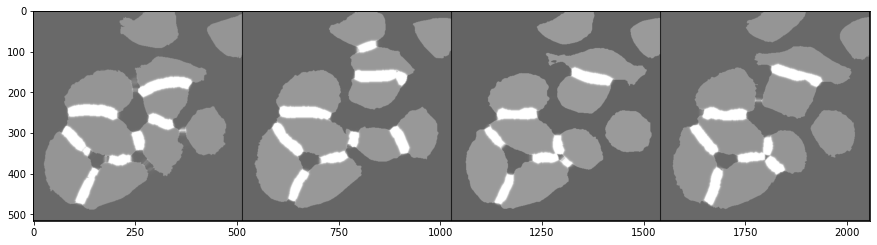

In [3]:
###########################################################################
# explore the data(testing)
###########################################################################

my_iter = iter(dic_train_loader)
sample = next(my_iter)
imgs, masks, markers, weight_maps = sample

imgs.shape
masks.shape
markers.shape
weight_maps.float().shape

grid = torchvision.utils.make_grid(weight_maps.unsqueeze(1), nrow = 4)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)))



In [4]:
###########################################################################
# DIC-C2DH-HeLa CNN class
###########################################################################
class dic_cnn(nn.Module):
    def __init__(self):
        super(dic_cnn, self).__init__()
        # down
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        # up
        self.conv11 = nn.Conv2d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv13 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv15 = nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv17 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        # final
        self.conv19 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, padding = 0)

    def forward(self, images):
        res_conv1 = F.relu(self.conv1(images))
        res_conv2 = F.relu(self.conv2(res_conv1))
        res_maxpool1 = F.max_pool2d(res_conv2, kernel_size = 2, stride = 2) 

        res_conv3 = F.relu(self.conv3(res_maxpool1))
        res_conv4 = F.relu(self.conv4(res_conv3))
        res_maxpool2 = F.max_pool2d(res_conv4, kernel_size = 2, stride = 2)

        res_conv5 = F.relu(self.conv5(res_maxpool2))
        res_conv6 = F.relu(self.conv6(res_conv5))
        res_maxpool3 = F.max_pool2d(res_conv6, kernel_size = 2, stride = 2)

        res_conv7 = F.relu(self.conv7(res_maxpool3))
        res_conv8 = F.relu(self.conv8(res_conv7))
        res_maxpool4 = F.max_pool2d(res_conv8, kernel_size = 2, stride = 2)

        res_conv9 = F.relu(self.conv9(res_maxpool4))
        res_conv10 = F.relu(self.conv10(res_conv9))
        
        res_up1 = nn.Upsample(scale_factor=2, mode = 'bilinear')(res_conv10)
        res_cat1 = torch.cat((res_up1, res_conv8), dim=1)
        res_conv11 = F.relu(self.conv11(res_cat1))
        res_conv12 = F.relu(self.conv12(res_conv11))

        res_up2 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv12)
        res_cat2 = torch.cat((res_up2, res_conv6), dim=1)
        res_conv13 = F.relu(self.conv13(res_cat2))
        res_conv14 = F.relu(self.conv14(res_conv13))

        res_up3 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv14)
        res_cat3 = torch.cat((res_up3, res_conv4), dim=1)
        res_conv15 = F.relu(self.conv15(res_cat3))
        res_conv16 = F.relu(self.conv16(res_conv15))

        res_up4 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv16)
        res_cat4 = torch.cat((res_up4, res_conv2), dim=1)
        res_conv17 = F.relu(self.conv17(res_cat4))
        res_conv18 = F.relu(self.conv18(res_conv17))

        output = self.conv19(res_conv18)
        #output = F.softmax(output, dim=1)

        return output




In [5]:
###########################################################################
# Training process, using GPU
# if you don't have a GPU which has a huage memory, then it doesn't work
###########################################################################
mask_net = dic_cnn().to('cuda')
marker_net = dic_cnn().to('cuda')

optimizer_marker = torch.optim.Adam(marker_net.parameters(), lr = 0.0003)
optimizer_mask = torch.optim.Adam(mask_net.parameters(), lr = 0.0003)
start_time = time()

def weighted_cross_entropy(preds, targets, weight_maps):
    logp = F.log_softmax(preds)
    logp = logp.gather(1, targets.view(4, 1, 512, 512))
    weighted_logp = (logp*weight_maps.unsqueeze(1)).view(4, -1)
    weighted_loss = weighted_logp.sum(1)/weight_maps.view(4, -1).sum(1)
    weighted_loss = -1. * weighted_loss.mean()
    return weighted_loss

for epoch in range(100):
    if epoch == 61:
        for param in optimizer_mask.param_groups:
            param['lr'] == 0.000003
        for param in optimizer_marker.param_groups:
            param['lr'] == 0.00003
    if epoch == 71:
        for param in optimizer_marker.param_groups:
            param['lr'] == 0.000003
    for index, batch in enumerate(dic_train_loader, 0):
        ## unpack data
        imgs, masks, markers, weight_maps = batch
        masks = masks.long()
        markers = markers.long()
        weight_maps = weight_maps.float()
        imgs = imgs.to('cuda')
        masks = masks.to('cuda')
        markers = markers.to('cuda')
        weight_maps = weight_maps.to('cuda')

        optimizer_marker.zero_grad()
        optimizer_mask.zero_grad()
        
        pred_markers = marker_net(imgs)
        loss_marker = weighted_cross_entropy(pred_markers, markers, weight_maps)
        loss_marker.backward()
        optimizer_marker.step()

        pred_masks = mask_net(imgs)
        loss_mask = F.cross_entropy(pred_masks, masks)
        loss_mask.backward()
        optimizer_mask.step()

        #plt.imshow(torch.argmax(pred_masks[0].cpu(), 0), cmap = 'gray')
        #plt.show()
    
    print('loss mask', loss_mask.item())
    print('loss marker', loss_marker.item())     
    print(f'Epoch {epoch} is finished, running time {time() - start_time}s')
    start_time = time()
torch.save(mask_net, 'mask_net.pkl')
torch.save(marker_net, 'marker_net.pkl')

loss mask 0.47775208950042725
loss marker 0.4300633668899536
Epoch 0 is finished, running time 35.00981831550598s
loss mask 0.4243250787258148
loss marker 0.39435404539108276
Epoch 1 is finished, running time 32.77369570732117s
loss mask 0.417938232421875
loss marker 0.37834784388542175
Epoch 2 is finished, running time 33.344353914260864s
loss mask 0.3972684144973755
loss marker 0.3688241243362427
Epoch 3 is finished, running time 33.710880756378174s
loss mask 0.3935088515281677
loss marker 0.34623366594314575
Epoch 4 is finished, running time 33.64330840110779s
loss mask 0.37767839431762695
loss marker 0.30626386404037476
Epoch 5 is finished, running time 33.70249342918396s
loss mask 0.39560240507125854
loss marker 0.25957661867141724
Epoch 6 is finished, running time 33.73043394088745s
loss mask 0.38407090306282043
loss marker 0.21393930912017822
Epoch 7 is finished, running time 33.73238158226013s
loss mask 0.37782934308052063
loss marker 0.19124238193035126
Epoch 8 is finished, ru

False

False

loss mask 0.06983469426631927
loss marker 0.028278842568397522
Epoch 61 is finished, running time 32.40391731262207s
loss mask 0.06587494909763336
loss marker 0.026653695851564407
Epoch 62 is finished, running time 32.39813709259033s
loss mask 0.062157563865184784
loss marker 0.027565661817789078
Epoch 63 is finished, running time 32.37630820274353s
loss mask 0.06648648530244827
loss marker 0.029001403599977493
Epoch 64 is finished, running time 32.384761095047s
loss mask 0.06961161643266678
loss marker 0.028162119910120964
Epoch 65 is finished, running time 32.675379037857056s
loss mask 0.0602005273103714
loss marker 0.03253708779811859
Epoch 66 is finished, running time 32.51283502578735s
loss mask 0.057962119579315186
loss marker 0.03225230425596237
Epoch 67 is finished, running time 33.40385580062866s
loss mask 0.06077370420098305
loss marker 0.031697750091552734
Epoch 68 is finished, running time 33.349895000457764s
loss mask 0.0576089546084404
loss marker 0.039346955716609955
Epo

False

loss mask 0.06582485139369965
loss marker 0.03473866358399391
Epoch 71 is finished, running time 32.59468412399292s
loss mask 0.05392846465110779
loss marker 0.031941741704940796
Epoch 72 is finished, running time 31.773935317993164s
loss mask 0.05659990385174751
loss marker 0.030127685517072678
Epoch 73 is finished, running time 31.838963985443115s
loss mask 0.05754103511571884
loss marker 0.030152376741170883
Epoch 74 is finished, running time 31.971487283706665s
loss mask 0.05548965185880661
loss marker 0.03152205049991608
Epoch 75 is finished, running time 31.798338651657104s
loss mask 0.05391810089349747
loss marker 0.030213313177227974
Epoch 76 is finished, running time 31.756023168563843s
loss mask 0.05297955870628357
loss marker 0.02540738508105278
Epoch 77 is finished, running time 31.75689697265625s
loss mask 0.05314796045422554
loss marker 0.02552134171128273
Epoch 78 is finished, running time 31.742095947265625s
loss mask 0.05135929584503174
loss marker 0.02867201529443264


array([0, 1], dtype=int64)

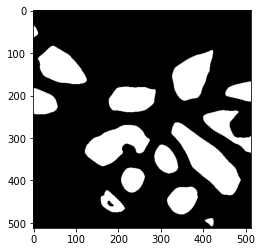

torch.Size([512, 512])

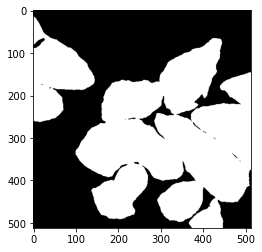

In [19]:
imgs = cv2.imread('DIC-C2DH-HeLa/Sequence 3/t010.tif', 0)
imgs = cv2.equalizeHist(imgs)
imgs = my_transform(imgs).unsqueeze(0)

mask_net = torch.load('mask_net.pkl')

marker_net = torch.load('marker_net.pkl')

pred = marker_net(imgs.to('cuda'))
pred = pred.to('cpu')
pred1 = pred[0]
mask = torch.argmax(pred1, 0)
np.unique(mask)
plt.imshow(torch.argmax(pred[0], 0), cmap = 'gray')
plt.show()

pred = mask_net(imgs.to('cuda'))
pred = pred.to('cpu')
pred1 = pred[0]
mask = torch.argmax(pred1, 0)
mask.shape
plt.imshow(mask, cmap = 'gray')
plt.show()


C:\Users\oyishyi\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


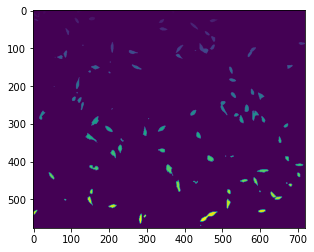

In [16]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

def my_watershed(img):
    img_array = np.array(img)
    distance = ndi.distance_transform_edt(img_array)
    local_maxi = peak_local_max(distance, indices = False, labels=img_array)
    markers = ndi.label(local_maxi)[0]
    return watershed(-distance, markers, mask = img_array)

gray = cv2.imread('PhC-C2DL-PSC/01/t001.tif', -1)
_, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

res = my_watershed(thresh)

plt.imshow(res)
